<h1> Create wide-and-deep Tensorflow model </h1>


<p>
Modelling using the high-level Estimator API  (https://www.tensorflow.org/api_docs/python/tf/estimator)


In [1]:
# change these to try this notebook out
BUCKET = 'cloud-ml-engine-da0042cda3acd8'
PROJECT = 'cloud-ml-engine-da0042cda3acd8'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [4]:
%bash
ls *.csv

eval.csv
train.csv


<h2> Create TensorFlow model using TensorFlow's Estimator API </h2>
<p>
First, write an input_fn to read the data.

In [5]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


In [6]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]
TRAIN_STEPS = 1000

In [7]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    def decode_csv(value_column):
      columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
      features = dict(zip(CSV_COLUMNS, columns))
      label = features.pop(LABEL_COLUMN)
      return features, label
    
    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
    dataset = (tf.data.TextLineDataset(file_list)  # Read text file
                 .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size=10*batch_size)
    else:
        num_epochs = 1 # end-of-input after this
 
    dataset = dataset.repeat(num_epochs).batch(batch_size)
    return dataset
  return _input_fn

Next, define the feature columns

In [8]:
# Define feature columns
def get_wide_deep():
  # Define column types
  is_male,mother_age,plurality,gestation_weeks = \
      [\
          tf.feature_column.categorical_column_with_vocabulary_list('is_male', 
                      ['True', 'False', 'Unknown']),
          tf.feature_column.numeric_column('mother_age'),
          tf.feature_column.categorical_column_with_vocabulary_list('plurality',
                      ['Single(1)', 'Twins(2)', 'Triplets(3)',
                       'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']),
          tf.feature_column.numeric_column('gestation_weeks')
      ]

  # Discretize
  age_buckets = tf.feature_column.bucketized_column(mother_age, 
                      boundaries=np.arange(15,45,1).tolist())
  gestation_buckets = tf.feature_column.bucketized_column(gestation_weeks, 
                      boundaries=np.arange(17,47,1).tolist())

  # Sparse columns are wide, have a linear relationship with the output
  wide = [is_male,
          plurality,
          age_buckets,
          gestation_buckets]

  # Feature cross all the wide columns and embed into a lower dimension
  crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=20000)
  embed = tf.feature_column.embedding_column(crossed, 3)

  # Continuous columns are deep, have a complex relationship with the output
  deep = [mother_age,
          gestation_weeks,
          embed]
  return wide, deep

To predict with the TensorFlow model, we also need a serving input function. We will want all the inputs from our user.

In [9]:
# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        'is_male': tf.placeholder(tf.string, [None]),
        'mother_age': tf.placeholder(tf.float32, [None]),
        'plurality': tf.placeholder(tf.string, [None]),
        'gestation_weeks': tf.placeholder(tf.float32, [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [10]:
# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
  wide, deep = get_wide_deep()
  EVAL_INTERVAL = 300
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 3)
  estimator = tf.estimator.DNNLinearCombinedRegressor(
                       model_dir = output_dir,
                       linear_feature_columns = wide,
                       dnn_feature_columns = deep,
                       dnn_hidden_units = [64, 32],
                       config = run_config)
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = TRAIN_STEPS)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('eval.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 60, # start evaluating after N seconds
                       throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
                       exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Finally, train!

In [11]:
# Run the model
shutil.rmtree('babyweight_trained', ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
train_and_evaluate('babyweight_trained')

INFO:tensorflow:Using config: {'_tf_random_seed': None, '_global_id_in_cluster': 0, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdedda31278>, '_save_summary_steps': 100, '_service': None, '_num_ps_replicas': 0, '_is_chief': True, '_master': '', '_save_checkpoints_secs': 300, '_train_distribute': None, '_session_config': None, '_model_dir': 'babyweight_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_keep_checkpoint_max': 3, '_task_id': 0, '_task_type': 'worker', '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 300 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tens

When I ran it, the final lines of the output (above) were:
<pre>
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.2693067, global_step = 1000, loss = 635.9226
INFO:tensorflow:Restoring parameters from babyweight_trained/model.ckpt-1000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: babyweight_trained/export/exporter/temp-1517899936/saved_model.pb
</pre>
The exporter directory contains the final model and the final RMSE (the average_loss) is 1.2693067

<h2> Monitor and experiment with training </h2>

In [12]:
from google.datalab.ml import TensorBoard
TensorBoard().start('./babyweight_trained')

TensorBoard was started successfully with pid 4764. Click here to access it.

4764

It should look something like this

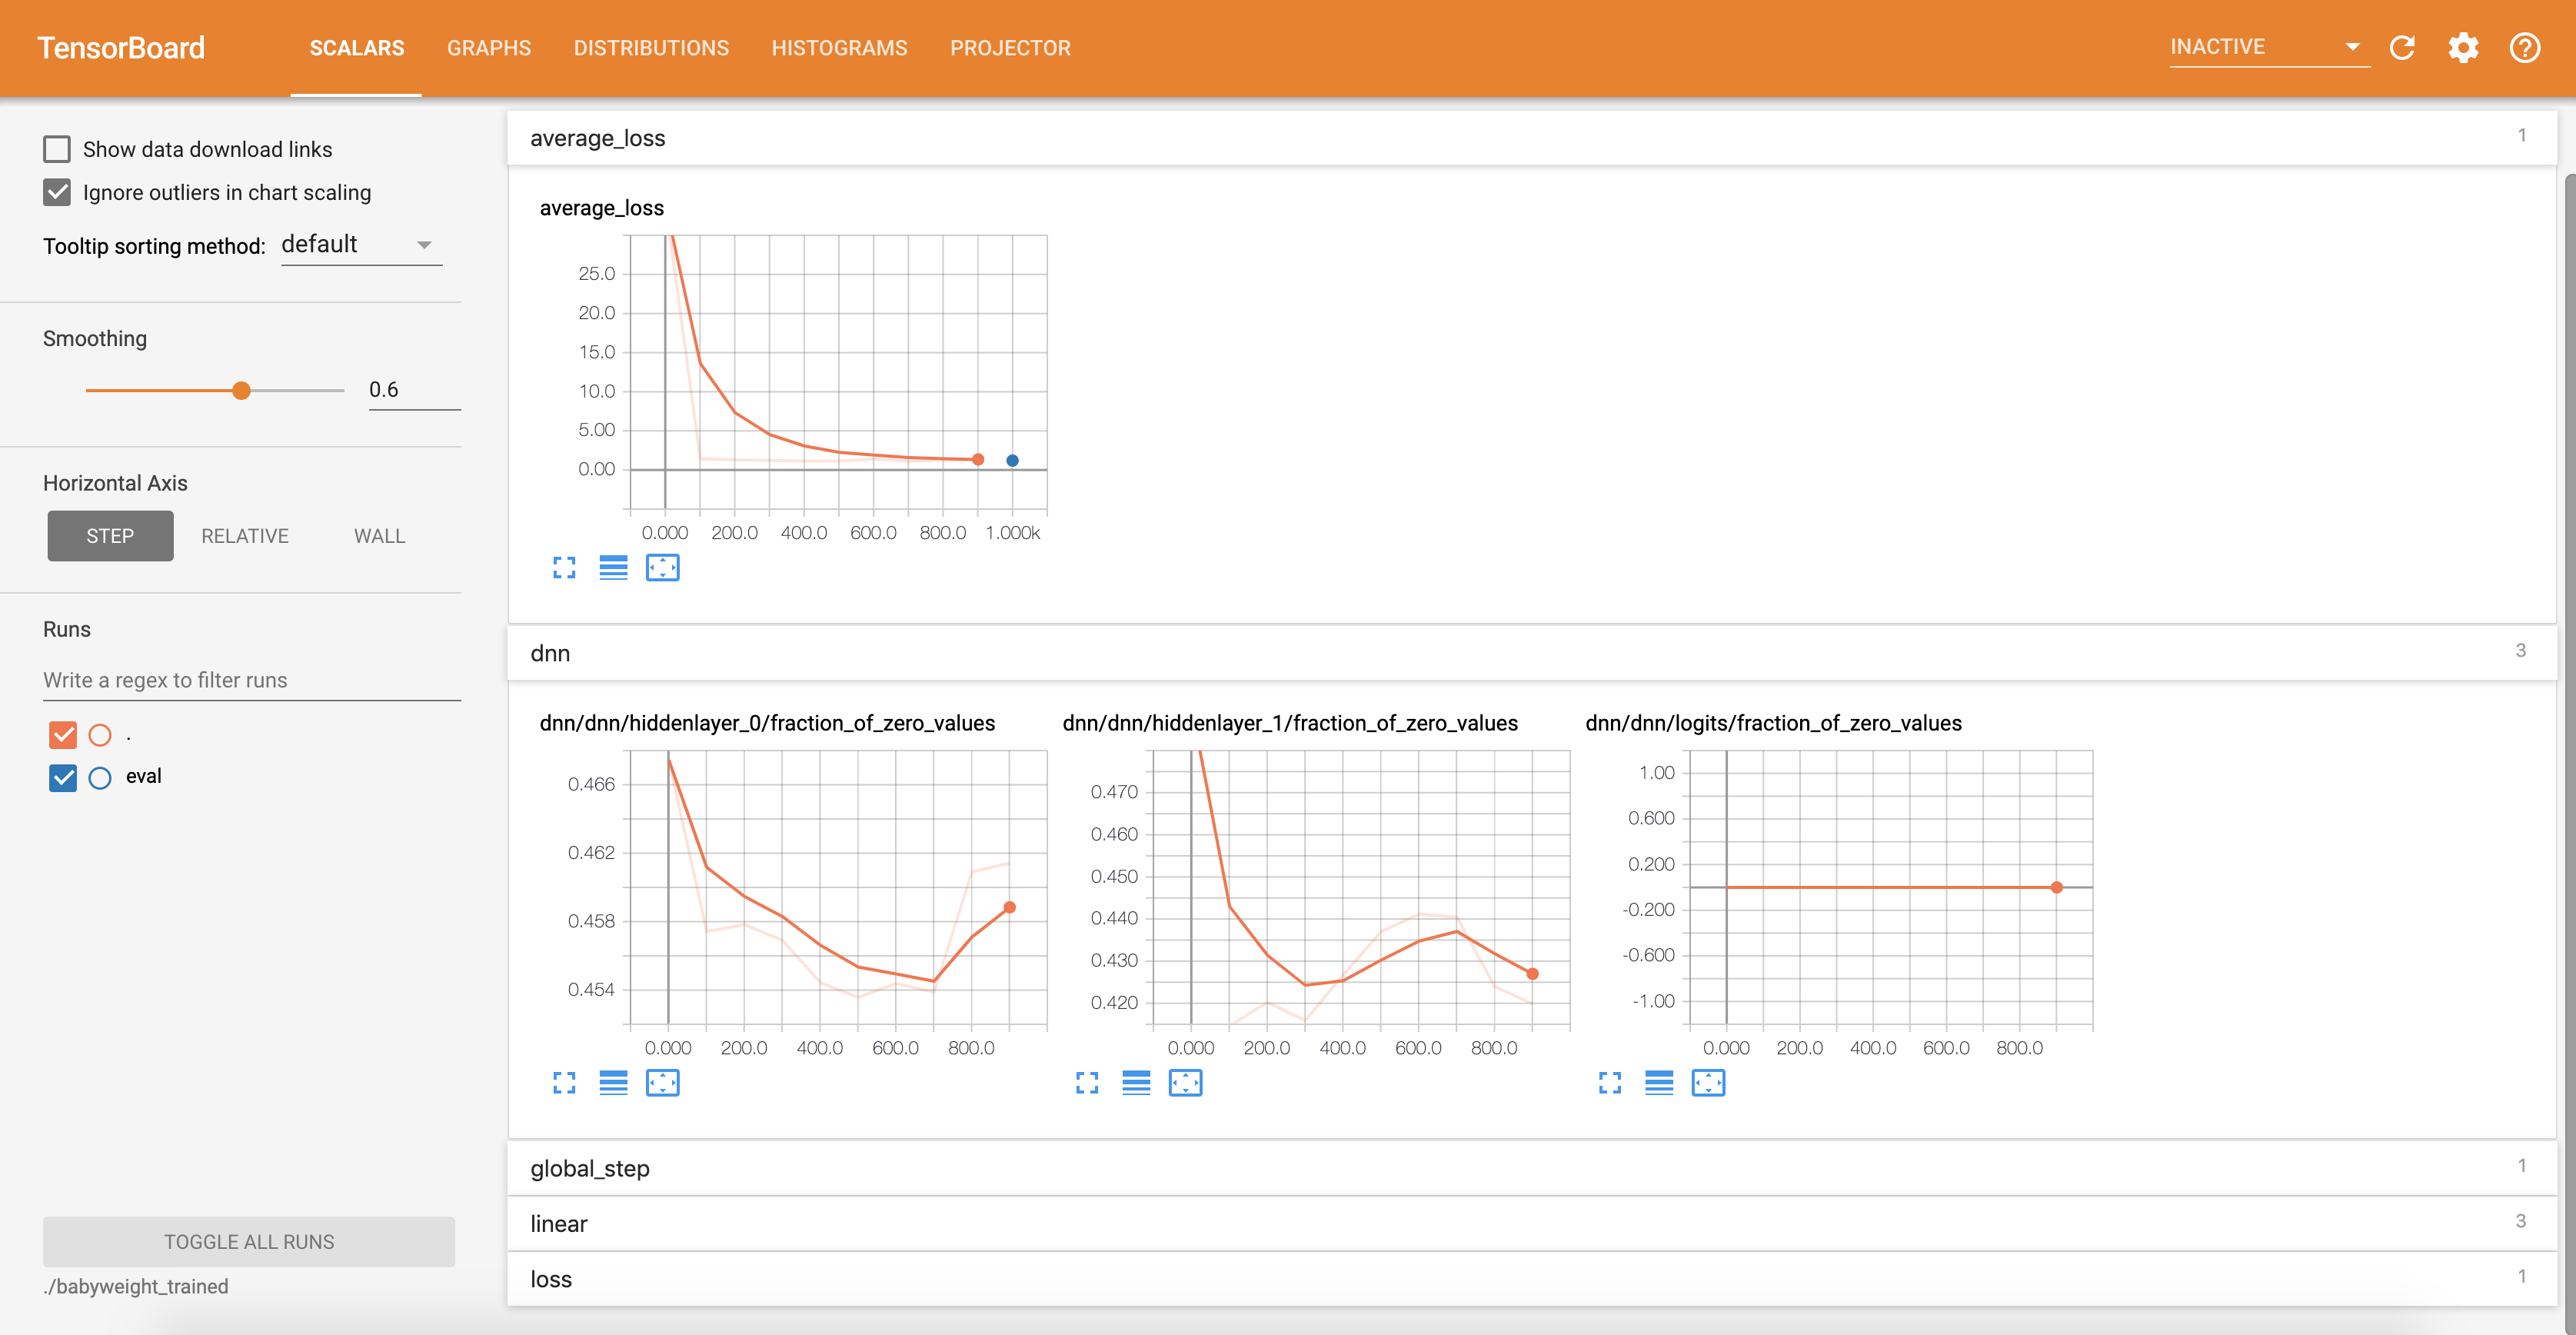

In TensorBoard, look at the learned embeddings to check wether they are getting clustered, how the weights for the hidden layers behaves and see what happens if this runs longer, also play with the batchsize to see what happens if it changes

In [13]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 4764
